In [1]:
"""
Based on the following code, we will explain how to use the SendAPI.
Some parts of the test code reuse the code listed at the following URL.
https://langchain-ai.github.io/langgraph/how-tos/map-reduce/
"""
import operator
from typing import Annotated, TypedDict

from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI
from langgraph.types import Send

from kenkenpa.builder import StateGraphBuilder

In [2]:
subjects_prompt = """Generate a comma separated list of between 2 and 5 examples related to: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one.

{jokes}"""

class Subjects(BaseModel):
    subjects: list[str]

class Joke(BaseModel):
    joke: str

class BestJoke(BaseModel):
    id: int = Field(description="Index of the best joke. starting with 0",ge=0)

model = ChatOpenAI(model="gpt-4o-mini")

class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str

class JokeState(TypedDict):
    subject: str

In [3]:
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

In [4]:
def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}


In [5]:
# :pencil: Define continue_to_jokes as a callable evaluation function.
def continue_to_jokes(state:OverallState, config, **kwargs):
    return [Send("generate_joke",{"subject":s}) for s in state["subjects"]]

In [6]:
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

In [7]:
# :pencil: Define a factory function.
def gen_generate_topics(factory_parameter,flow_parameter):
    return generate_topics

def gen_generate_joke(factory_parameter,flow_parameter):
    return generate_joke

def gen_best_joke(factory_parameter,flow_parameter):
    return best_joke


In [8]:
graph_settings = {
    "graph_type":"stategraph",
    "flow_parameter":{
        "name":"React-Agent",
        # :pencil: Define the fields equivalent to OverallState here.
        "state" : [
            {
                "field_name": "topic",
                "type": "str",
            },
            {
                "field_name": "subjects",
                "type": "list",
            },
            {
                "field_name": "jokes",
                "type": "list",
                "reducer":"operator_add"
            },
            {
                "field_name": "best_selected_joke",
                "type": "str",
            },
        ],
    },
    "flows":[
        { # generate_topics node
            "graph_type":"node",
            "flow_parameter":{
                "name":"generate_topics",
                "factory":"gen_generate_topics",
            },
        },
        { # generate_joke node
            "graph_type":"node",
            "flow_parameter":{
                "name":"generate_joke",
                "factory":"gen_generate_joke",
            },
        },
        { # best_joke node
            "graph_type":"node",
            "flow_parameter":{
                "name":"best_joke",
                "factory":"gen_best_joke",
            },
        },
        {# edge START -> generate_topics
            "graph_type":"edge",
            "flow_parameter":{
                "start_key":"START",
                "end_key":"generate_topics"
            },
        },
        {# coditional edge generate_topics -> continue_to_jokes
            "graph_type":"configurable_conditional_edge",
            "flow_parameter":{
                "start_key":"generate_topics",
                "path_map":["generate_joke"], # :pencil: Specify the path_map
                "conditions":[
                    # :pencil: Only set the default to call continue_to_jokes
                    # without defining an evaluation expression in the conditions.
                    {"default": {"type": "function", "name": "continue_to_jokes"}} 
                ]
            },
        },
        {# edge generate_joke -> best_joke
            "graph_type":"edge",
            "flow_parameter":{
                "start_key":"generate_joke",
                "end_key":"best_joke"
            },
        },
        {# edge best_joke -> END
            "graph_type":"edge",
            "flow_parameter":{
                "start_key":"best_joke",
                "end_key":"END"
            },
        },
    ]
}

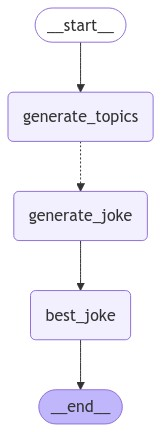

{'generate_topics': {'subjects': ['dogs', 'cats', 'elephants', 'giraffes', 'dolphins']}}
{'generate_joke': {'jokes': ['Why did the cat sit on the computer? Because it wanted to keep an eye on the mouse!']}}
{'generate_joke': {'jokes': ["Why do elephants never use computers? Because they're afraid of the mouse!"]}}
{'generate_joke': {'jokes': ["Why did the dog sit in the shade? Because he didn't want to become a hot dog!"]}}
{'generate_joke': {'jokes': ["Why don't giraffes make good secret agents? Because they're always sticking their necks out!"]}}
{'generate_joke': {'jokes': ['Why did the dolphin bring a towel to the party? Because it wanted to have a whale of a time!']}}
{'best_joke': {'best_selected_joke': 'Why did the dolphin bring a towel to the party? Because it wanted to have a whale of a time!'}}


In [9]:
# Generate the StateGraphBuilder from graph_settings.
stategraph_builder = StateGraphBuilder(graph_settings)

# Register the reducer to be used in the StateGraphBuilder.
stategraph_builder.add_reducer("operator_add",operator.add)

# Register the node factory with the stategraph_builder.
stategraph_builder.add_node_factory("gen_generate_topics",gen_generate_topics)
stategraph_builder.add_node_factory("gen_generate_joke",gen_generate_joke)
stategraph_builder.add_node_factory("gen_best_joke",gen_best_joke)

# Similarly, the evaluation function is also registered.
stategraph_builder.add_evaluete_function("continue_to_jokes", continue_to_jokes)

# The gen_stategraph method generates a compilable StateGraph.
stategraph = stategraph_builder.gen_stategraph()

# From here on, we will write the code following the general usage of LangGraph.
# Please note that this library does not involve config and checkpointer.
app = stategraph.compile()

from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "animals"}):
    print(s)